In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from sklearn.cluster import KMeans
from collections import Counter

In [79]:
train_dir = os.getcwd() + "/../train/"
train_files = os.listdir(train_dir)

# UTILS

def get_rand_img_path():
    return train_dir + random.choice(train_files)

def get_img(label):
    path = os.path.join(train_dir,f"{label}-0.png")
    img = cv2.imread(path)
    return img

def get_label(img_path):
    filename = os.path.basename(img_path)
    label = filename.split('-')[0]
    return label

def get_rand_img():
    path = get_rand_img_path()
    label = get_label(path)
    img = cv2.imread(path)
    return img, label

def show_img(img, title=None):
    plt.figure()
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [211]:
def remove_lines(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV)
    
    # Remove lines
    removed = cv2.inpaint(img, mask, 3, cv2.INPAINT_NS)
    
    return removed

In [212]:
def get_top_colors(img, n_colors, colorspace='HSV', ignore_white=True, white_v_thresh=200, white_s_thresh=30):
    """
    Get the top n_colors present in an image based on frequency (ignoring white).

    Args:
        img: Input BGR image.
        n_colors: Number of most frequent colors to return (characters + black lines).
        colorspace: 'HSV' or 'RGB' (default HSV).
        ignore_white: Whether to ignore white pixels.
        white_v_thresh: V threshold to consider pixel white (HSV only).
        white_s_thresh: S threshold to consider pixel white (HSV only).

    Returns:
        colors: np.ndarray of shape (<= n_colors, 3) with the most frequent colors.
    """
    # Convert color space
    if colorspace.upper() == 'HSV':
        img_c = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif colorspace.upper() == 'RGB':
        img_c = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        raise ValueError("colorspace must be 'HSV' or 'RGB'")

    # Flatten pixels
    pixels = img_c.reshape(-1, 3)
    
    # Optionally ignore white
    if ignore_white and colorspace.upper() == 'HSV':
        mask = ~((pixels[:,1] <= white_s_thresh) & (pixels[:,2] >= white_v_thresh))
        pixels = pixels[mask]

    # Convert to tuples for counting
    pixels_tuples = [tuple(p) for p in pixels]
    counts = Counter(pixels_tuples)
    
    # Take top n_colors
    top_colors = np.array([c for c, _ in counts.most_common(n_colors)], dtype=np.uint8)
    
    return top_colors

def show_colors(colors, label):
    swatch = np.zeros((50, 50 * len(colors), 3), dtype=np.uint8)
    for i, c in enumerate(colors):
        swatch[:, i*50:(i+1)*50] = c
    show_img(cv2.cvtColor(swatch, cv2.COLOR_HSV2BGR), title=label)

def mask_by_color(img, target_color, tol=30, colorspace='HSV'):
    """
    Create a binary mask isolating pixels close to a target color.

    Args:
        img: Input BGR image.
        target_color: Tuple/list of 3 values (HSV or RGB) to target.
        tol: Tolerance for each channel (+/- tol).
        colorspace: 'HSV' or 'RGB'. Default 'HSV'.

    Returns:
        mask: Binary mask (uint8) where 255 indicates pixels matching target color.
    """
    # Convert image if needed
    if colorspace.upper() == 'HSV':
        img_c = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif colorspace.upper() == 'RGB':
        img_c = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        raise ValueError("colorspace must be 'HSV' or 'RGB'")

    # Compute lower and upper bounds
    lower = np.array([max(0, int(c) - tol) for c in target_color], dtype=np.uint8)
    upper = np.array([min(255, int(c) + tol) for c in target_color], dtype=np.uint8)

    # Generate mask
    mask = cv2.inRange(img_c, lower, upper)
    
    # Optional: clean small noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    
    return mask

def show_masked_images(img, colors, tol=20):
    """
    For each target color, create a mask and display the masked image.
    
    Args:
        img: Original BGR image
        colors: List/array of target colors (HSV or RGB)
        tol: Tolerance for color matching
    """
    for i, color in enumerate(colors):
        # Generate mask
        mask = mask_by_color(img, target_color=color, tol=tol)
        
        # Apply mask: keep color pixels, set rest to black
        masked_img = cv2.bitwise_and(img, img, mask=mask)
        
        # Show
        plt.figure()
        plt.title(f"Masked image for color {i}")
        plt.axis('off')
        plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))
        plt.show()

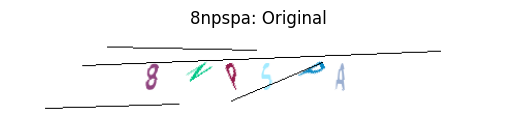

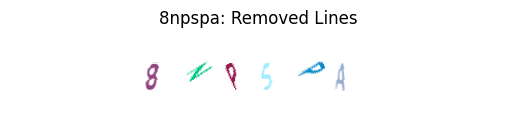

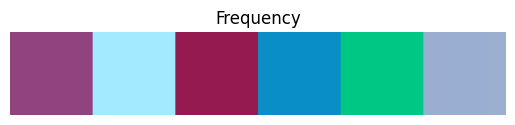

In [214]:
img, label = get_rand_img()
show_img(img, title=f"{label}: Original")

img = remove_lines(img)
colors = get_top_colors(img, n_colors=len(label))
show_img(img, title=f"{label}: Removed Lines")

show_colors(colors, label="Frequency")

In [215]:
def log_gabor_filter_bank(shape, n_orient=8, n_scale=4, min_wavelength=3, mult=2.1, sigma_onf=0.55):
    """Generate a bank of Log-Gabor filters."""
    rows, cols = shape
    y, x = np.mgrid[-0.5:0.5:(rows*1j), -0.5:0.5:(cols*1j)]
    radius = np.sqrt(x**2 + y**2)
    radius[rows//2, cols//2] = 1  # avoid log(0)
    theta = np.arctan2(-y, x)

    filters = []
    for s in range(n_scale):
        wavelength = min_wavelength * (mult ** s)
        fo = 1.0 / wavelength
        log_gabor_radial = np.exp((-(np.log(radius / fo)) ** 2) / (2 * (np.log(sigma_onf)) ** 2))
        log_gabor_radial[radius < 0.001] = 0  # remove DC

        for o in range(n_orient):
            angl = o * np.pi / n_orient
            ds = np.sin(theta) * np.cos(angl) - np.cos(theta) * np.sin(angl)
            dc = np.cos(theta) * np.cos(angl) + np.sin(theta) * np.sin(angl)
            dtheta = np.abs(np.arctan2(ds, dc))
            spread = np.exp((-dtheta ** 2) / (2 * (np.pi / n_orient * 0.55) ** 2))

            filt = log_gabor_radial * spread
            filters.append(filt)
    return filters

def apply_log_gabor(img_gray, n_orient=8, n_scale=4):
    """Apply a log-gabor filter bank to a grayscale image."""
    # FFT
    img_f = np.fft.fft2(img_gray)
    filters = log_gabor_filter_bank(img_gray.shape, n_orient, n_scale)
    
    responses = []
    for filt in filters:
        result = np.fft.ifft2(img_f * np.fft.fftshift(filt))
        responses.append(np.abs(result))
    
    combined = np.max(np.stack(responses, axis=-1), axis=-1)
    combined = cv2.normalize(combined, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return combined


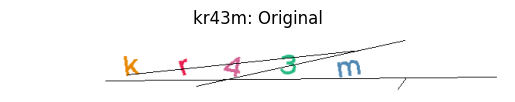

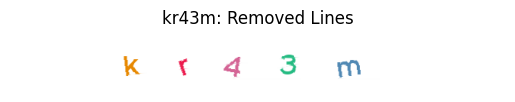

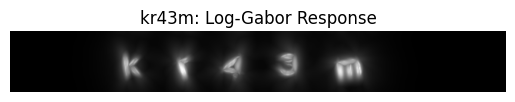

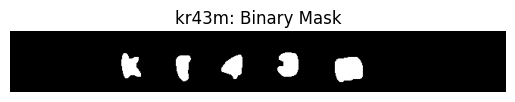

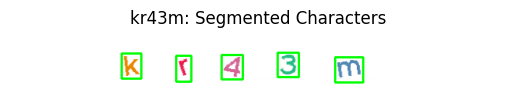

In [216]:
img, label = get_rand_img()
show_img(img, title=f"{label}: Original")

img_clean = remove_lines(img)
show_img(img_clean, title=f"{label}: Removed Lines")

gray = cv2.cvtColor(img_clean, cv2.COLOR_BGR2GRAY)
seg_map = apply_log_gabor(gray, n_orient=8, n_scale=4)

show_img(seg_map, title=f"{label}: Log-Gabor Response")

# 1. Normalize and threshold
norm = cv2.normalize(seg_map, None, 0, 255, cv2.NORM_MINMAX)
_, binary = cv2.threshold(norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 2. Morphological cleanup
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)
binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)

show_img(binary, title=f"{label}: Binary Mask")

# 3. Connected components (each ≈ one character)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)

# 4. Filter components by size to remove noise
char_regions = []
h, w = binary.shape
for i in range(1, num_labels):  # skip background
    x, y, bw, bh, area = stats[i]
    if area > 50 and bh > h * 0.3:  # tune thresholds to your dataset
        char_regions.append((x, y, bw, bh))

# 5. Sort characters left-right
char_regions.sort(key=lambda r: r[0])

# 6. Visualize results
img_vis = img_clean.copy()
for (x, y, bw, bh) in char_regions:
    cv2.rectangle(img_vis, (x, y), (x+bw, y+bh), (0, 255, 0), 2)

show_img(img_vis, title=f"{label}: Segmented Characters")

# 7. Optional: extract individual masks
chars = [binary[y:y+bh, x:x+bw] for (x, y, bw, bh) in char_regions]


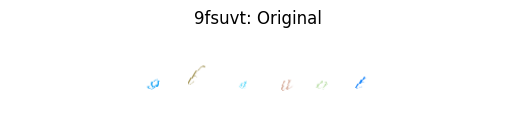

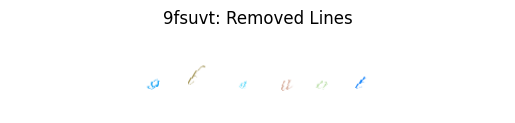

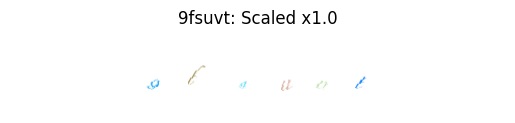

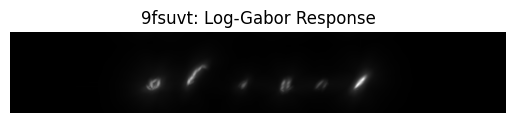

In [219]:
img, label = get_rand_img()
show_img(img, title=f"{label}: Original")

img_clean = remove_lines(img)
show_img(img_clean, title=f"{label}: Removed Lines")

# Scale up for segmentation test
scale = 1.0  # try 2× first, or 3× if the original CAPTCHA is small
img_scaled = cv2.resize(img_clean, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
show_img(img_scaled, title=f"{label}: Scaled x{scale}")

gray = cv2.cvtColor(img_scaled, cv2.COLOR_BGR2GRAY)
seg_map = apply_log_gabor(gray, n_orient=8, n_scale=4)

show_img(seg_map, title=f"{label}: Log-Gabor Response")

In [ ]:
def segment_by_stroke_width(img_bgr, min_width=2, max_width=10):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (3,3), 0)

    # 1. Edge detection
    edges = cv2.Canny(gray, 80, 150)

    # 2. Distance transform on inverted edges
    dist = cv2.distanceTransform(255 - edges, cv2.DIST_L2, 3)

    # 3. Threshold by width range
    # scale factor 2 because distance transform ≈ half the stroke width
    mask = ((dist >= min_width/2) & (dist <= max_width/2)).astype(np.uint8) * 255

    # 4. Morphological cleanup
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

    # 5. Connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
    h, w = gray.shape
    boxes = []
    for i in range(1, num_labels):
        x, y, bw, bh, area = stats[i]
        if area > 50 and bh > h*0.2:
            boxes.append((x, y, bw, bh))
    boxes.sort(key=lambda r: r[0])

    # 6. Visualization
    vis = img_bgr.copy()
    for (x, y, bw, bh) in boxes:
        cv2.rectangle(vis, (x, y), (x+bw, y+bh), (0,255,0), 2)

    return vis, mask, boxes

def extract_characters_from_boxes(img, boxes, out_size=(64, 64), pad_ratio=0.25):
    chars = []

    for (x, y, bw, bh) in boxes:
        # Crop region
        crop = img[y:y+bh, x:x+bw]

        # Compute padding (as fraction of max dimension)
        max_side = max(bw, bh)
        pad = int(max_side * pad_ratio)

        # Pad evenly on all sides
        crop_padded = cv2.copyMakeBorder(
            crop,
            pad, pad, pad, pad,
            cv2.BORDER_CONSTANT,
            value=[255, 255, 255]  # white background
        )

        # Resize to standard size (e.g., 64×64)
        crop_resized = cv2.resize(crop_padded, out_size, interpolation=cv2.INTER_AREA)
        chars.append(crop_resized)

    return chars

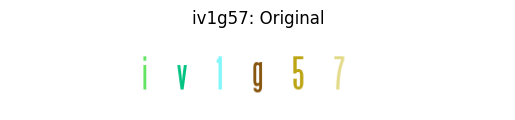

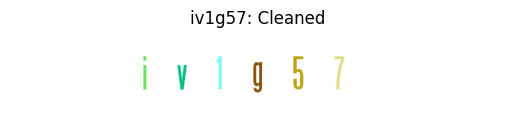

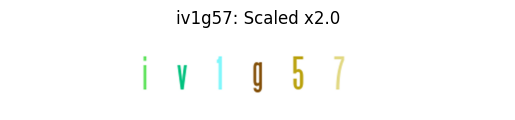

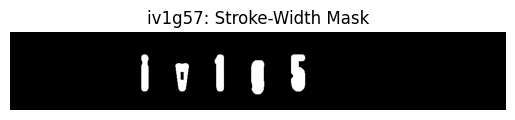

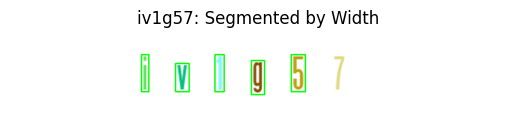

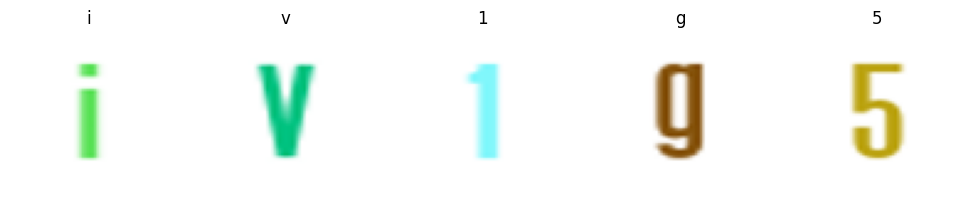

Number of characters expected: 6
Number of characters extracted: 5


In [134]:
img, label = get_rand_img()
show_img(img, title=f"{label}: Original")

img_clean = remove_lines(img)
show_img(img_clean, title=f"{label}: Cleaned")

scale = 2.0  # try 2× first, or 3× if the original CAPTCHA is small
img_scaled = cv2.resize(img_clean, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
show_img(img_scaled, title=f"{label}: Scaled x{scale}")

vis, mask, boxes = segment_by_stroke_width(img_scaled, min_width=2, max_width=8)
show_img(mask, title=f"{label}: Stroke-Width Mask")
show_img(vis, title=f"{label}: Segmented by Width")

# --- Extract individual, padded, same-size characters ---
chars = extract_characters_from_boxes(img_scaled, boxes, out_size=(64,64))

# --- Plot the extracted characters ---
n = len(chars)
cols = min(n, 8)
rows = (n + cols - 1) // cols

plt.figure(figsize=(cols*2, rows*2))
for i, ch in enumerate(chars):
    plt.subplot(rows, cols, i+1)
    if len(ch.shape) == 2:
        plt.imshow(ch, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(ch, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    if i < len(label):
        plt.title(label[i])
plt.tight_layout()
plt.show()

expected_len = len(label)
extracted_len = len(chars)

print("Number of characters expected:", expected_len)
print("Number of characters extracted:", extracted_len)

In [137]:
# PIPELINE
def stroke_width_process(img):

    img_clean = remove_lines(img)
    
    scale = 2.0
    img_scaled = cv2.resize(img_clean, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)

    vis, mask, boxes = segment_by_stroke_width(img_clean, min_width=2, max_width=8)

    # --- Extract individual, padded, same-size characters ---
    chars = extract_characters_from_boxes(img_clean, boxes, out_size=(64,64))

    return chars

In [136]:
# Normal Scale
results = [0, 0]

rand_imgs = random.sample(train_files, 5000)
for f in rand_imgs:
    img = cv2.imread(train_dir + f)
    chars = stroke_width_process(img)
    if len(chars) == len(f[:-6]):
        results[0] += 1
    else:
        results[1] += 1

print(results, results[0]/sum(results))

[2592, 2408] 0.5184


In [ ]:
# Scaled x2
results = [0, 0]

rand_imgs = random.sample(train_files, 5000)
for f in rand_imgs:
    img = cv2.imread(train_dir + f)
    chars = stroke_width_process(img)
    if len(chars) == len(f[:-6]):
        results[0] += 1
    else:
        results[1] += 1

print(results, results[0]/sum(results))

[3149, 1851] 0.6298


In [138]:
def segment_by_stroke_width_robust(img, min_width=2, max_width=8, out_size=(32,32), pad_ratio=0.25):
    """
    Robust stroke-width + color-based segmentation.
    Returns:
        vis: scaled image with bounding boxes
        boxes: list of bounding boxes (x,y,w,h)
        chars: list of extracted, padded, resized character images
    """
    # 1. Upscale handled outside if needed; assume img is already scaled
    img_scaled = img.copy()
    h, w = img_scaled.shape[:2]
    
    # 2. Convert to perceptual grayscale and apply CLAHE
    gray = cv2.cvtColor(img_scaled, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    
    # 3. Stroke-width mask (edges + distance transform)
    edges = cv2.Canny(gray, 80, 150)
    dist = cv2.distanceTransform(255 - edges, cv2.DIST_L2, 3)
    mask_sw = ((dist >= min_width/2) & (dist <= max_width/2)).astype(np.uint8) * 255
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    mask_sw = cv2.morphologyEx(mask_sw, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask_sw = cv2.morphologyEx(mask_sw, cv2.MORPH_OPEN, kernel, iterations=1)
    
    # 4. Color-based mask for light colors (yellow / pale tones)
    b, g, r = cv2.split(img_scaled)
    mask_color = ((r > 150) & (g > 150) & (b < 120)).astype(np.uint8) * 255  # yellowish
    mask_color = cv2.morphologyEx(mask_color, cv2.MORPH_CLOSE, kernel, iterations=1)
    
    # 5. Merge masks
    final_mask = cv2.bitwise_or(mask_sw, mask_color)
    
    # 6. Connected components -> bounding boxes
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(final_mask, connectivity=8)
    boxes = []
    for i in range(1, num_labels):
        x, y, bw, bh, area = stats[i]
        if area > 50 and bh > h * 0.2:
            boxes.append((x, y, bw, bh))
    boxes.sort(key=lambda r: r[0])
    
    # 7. Visualization (green boxes on original image)
    vis = img_scaled.copy()
    for (x, y, bw, bh) in boxes:
        cv2.rectangle(vis, (x, y), (x + bw, y + bh), (0, 255, 0), 2)
    
    # 8. Extract characters (from original image, padded, resized)
    chars = []
    for (x, y, bw, bh) in boxes:
        crop = img_scaled[y:y+bh, x:x+bw]
        max_side = max(bw, bh)
        pad = int(max_side * pad_ratio)
        crop_padded = cv2.copyMakeBorder(crop, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=[255,255,255])
        crop_resized = cv2.resize(crop_padded, out_size, interpolation=cv2.INTER_AREA)
        chars.append(crop_resized)
    
    return vis, final_mask, boxes, chars


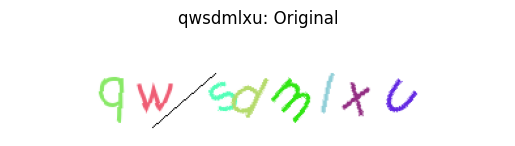

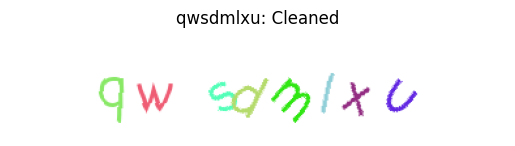

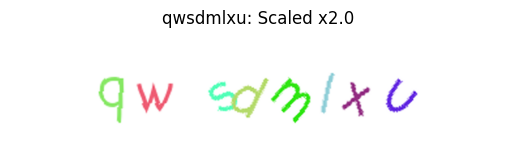

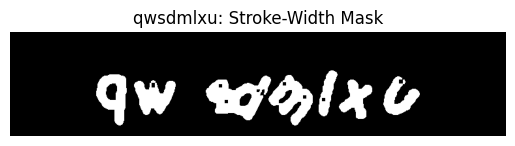

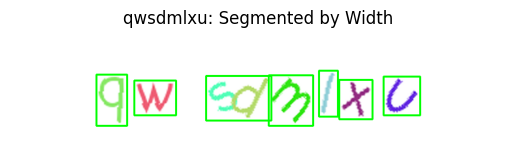

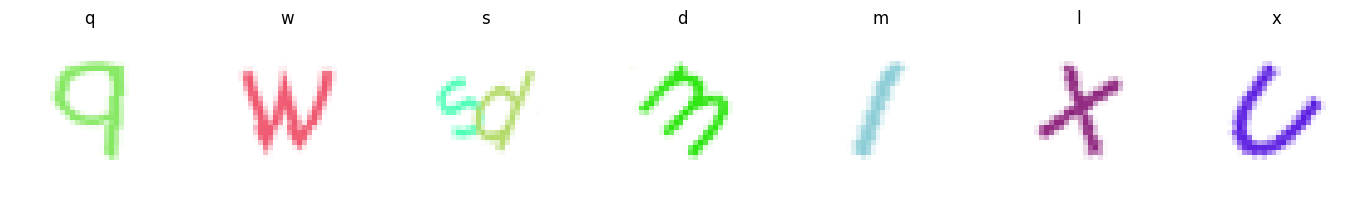

Number of characters expected: 8
Number of characters extracted: 7


In [ ]:
img, label = get_rand_img()
show_img(img, title=f"{label}: Original")

img_clean = remove_lines(img)
show_img(img_clean, title=f"{label}: Cleaned")

scale = 2.0
img_scaled = cv2.resize(img_clean, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
show_img(img_scaled, title=f"{label}: Scaled x{scale}")

vis, mask, boxes, chars = segment_by_stroke_width_robust(img_scaled, min_width=2, max_width=8)
show_img(mask, title=f"{label}: Stroke-Width Mask")
show_img(vis, title=f"{label}: Segmented by Width")

# --- Plot the extracted characters ---
n = len(chars)
cols = min(n, 8)
rows = (n + cols - 1) // cols

plt.figure(figsize=(cols*2, rows*2))
for i, ch in enumerate(chars):
    plt.subplot(rows, cols, i+1)
    if len(ch.shape) == 2:
        plt.imshow(ch, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(ch, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    if i < len(label):
        plt.title(label[i])
plt.tight_layout()
plt.show()

expected_len = len(label)
extracted_len = len(chars)

print("Number of characters expected:", expected_len)
print("Number of characters extracted:", extracted_len)

In [144]:
# High contrast - 1x
def stroke_width_process(img):

    img_clean = remove_lines(img)
    vis, mask, boxes, chars = segment_by_stroke_width_robust(img_clean, min_width=2, max_width=8)

    return chars

results = [0, 0]

rand_imgs = random.sample(train_files, 5000)
for f in rand_imgs:
    img = cv2.imread(train_dir + f)
    chars = stroke_width_process(img)
    if len(chars) == len(f[:-6]):
        results[0] += 1
    else:
        results[1] += 1

print(results, results[0]/sum(results))

[3042, 1958] 0.6084


In [147]:
# High contrast - 4x
def stroke_width_process(img):

    img_clean = remove_lines(img)
    
    scale = 4.0
    img_scaled = cv2.resize(img_clean, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)

    vis, mask, boxes, chars = segment_by_stroke_width_robust(img_scaled, min_width=2, max_width=8)

    return chars

results = [0, 0]

rand_imgs = random.sample(train_files, 5000)
for f in rand_imgs:
    img = cv2.imread(train_dir + f)
    chars = stroke_width_process(img)
    if len(chars) == len(f[:-6]):
        results[0] += 1
    else:
        results[1] += 1

print(results, results[0]/sum(results))

[3046, 1954] 0.6092


In [ ]:
# High contrast - 2x
def stroke_width_process(img):

    img_clean = remove_lines(img)
    
    scale = 2.0
    img_scaled = cv2.resize(img_clean, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)

    vis, mask, boxes, chars = segment_by_stroke_width_robust(img_scaled, min_width=2, max_width=8)

    return chars

results = [0, 0]

rand_imgs = random.sample(train_files, 5000)
for f in rand_imgs:
    img = cv2.imread(train_dir + f)
    chars = stroke_width_process(img)
    if len(chars) == len(f[:-6]):
        results[0] += 1
    else:
        results[1] += 1

print(results, results[0]/sum(results))

[3653, 1347] 0.7306


In [188]:
def segment_by_color_stroke_width(img, min_width=2, max_width=8, out_size=(32,32), pad_ratio=0.25):
    """
    Segment CAPTCHA characters using stroke-width + per-color separation.
    
    Returns:
        vis: image with green bounding boxes
        final_mask: merged mask of all detected regions
        boxes: list of bounding boxes
        chars: list of cropped, padded, resized character images
    """
    img_scaled = img.copy()
    h, w = img_scaled.shape[:2]
    
    # --- Step 1: Stroke-width mask (grayscale + CLAHE + edges) ---
    gray = cv2.cvtColor(img_scaled, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    
    edges = cv2.Canny(gray, 80, 150)
    dist = cv2.distanceTransform(255 - edges, cv2.DIST_L2, 3)
    mask_sw = ((dist >= min_width/2) & (dist <= max_width/2)).astype(np.uint8) * 255
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    mask_sw = cv2.morphologyEx(mask_sw, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask_sw = cv2.morphologyEx(mask_sw, cv2.MORPH_OPEN, kernel, iterations=1)
    
    # --- Step 2: Convert to HSV for color separation ---
    hsv = cv2.cvtColor(img_scaled, cv2.COLOR_BGR2HSV)
    h_chan, s_chan, v_chan = cv2.split(hsv)
    
    # --- Step 3: Detect unique hues (ignore low saturation/brightness) ---
    sat_thresh = 50
    val_thresh = 50
    mask_color = np.zeros_like(mask_sw)

    unique_hues = np.unique(h_chan[(s_chan > sat_thresh) & (v_chan > val_thresh)])

    for hue in unique_hues:
        # Compute hue difference correctly
        h_diff = np.minimum(np.abs(h_chan.astype(np.int16) - int(hue)),
                            180 - np.abs(h_chan.astype(np.int16) - int(hue)))
        hue_mask = ((h_diff <= 5) & (s_chan > sat_thresh) & (v_chan > val_thresh)).astype(np.uint8) * 255
        mask_color = cv2.bitwise_or(mask_color, hue_mask)
    
    # --- Step 4: Merge stroke-width and color masks ---
    final_mask = cv2.bitwise_or(mask_sw, mask_color)
    
    # --- Step 5: Connected components for bounding boxes ---
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(final_mask, connectivity=8)
    boxes = []
    for i in range(1, num_labels):
        x, y, bw, bh, area = stats[i]
        if area > 50 and bh > h * 0.2:
            boxes.append((x, y, bw, bh))
    boxes.sort(key=lambda r: r[0])
    
    # --- Step 6: Visualization ---
    vis = img_scaled.copy()
    for (x, y, bw, bh) in boxes:
        cv2.rectangle(vis, (x, y), (x+bw, y+bh), (0,255,0), 2)
    
    # --- Step 7: Extract characters ---
    chars = []
    for (x, y, bw, bh) in boxes:
        crop = img_scaled[y:y+bh, x:x+bw]
        max_side = max(bw, bh)
        pad = int(max_side * pad_ratio)
        crop_padded = cv2.copyMakeBorder(crop, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=[255,255,255])
        crop_resized = cv2.resize(crop_padded, out_size, interpolation=cv2.INTER_AREA)
        chars.append(crop_resized)
    
    return vis, final_mask, boxes, chars


### Overlapping Test

In [202]:
def split_by_top_colors(img_bgr, colors, colorspace='HSV', pad_ratio=0.25, out_size=(64,64)):
    """
    Given a BGR image and a list of dominant colors, create masks for each color,
    extract sub-characters, pad/resize, and return a list of cropped images.
    """
    if colorspace.upper() == 'HSV':
        img_c = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    elif colorspace.upper() == 'RGB':
        img_c = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    else:
        raise ValueError("colorspace must be 'HSV' or 'RGB'")
    
    sub_chars = []
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    
    for color in colors:
        # Compute hue difference for HSV, or simple channel comparison for RGB
        if colorspace.upper() == 'HSV':
            h_diff = np.minimum(np.abs(img_c[:,:,0].astype(np.int16) - int(color[0])),
                                180 - np.abs(img_c[:,:,0].astype(np.int16) - int(color[0])))
            mask = (h_diff <= 5).astype(np.uint8) * 255
        else:  # RGB
            mask = np.all(np.abs(img_c - color) <= 10, axis=2).astype(np.uint8) * 255
        
        # Morphology to clean mask
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
        
        # Extract connected components
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
        for i in range(1, num_labels):
            x, y, w, h, area = stats[i]
            if area < 10:
                continue
            crop = img_bgr[y:y+h, x:x+w]
            
            # Pad to square
            max_side = max(w, h)
            pad = int(max_side * pad_ratio)
            crop_padded = cv2.copyMakeBorder(crop, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=[255,255,255])
            crop_resized = cv2.resize(crop_padded, out_size, interpolation=cv2.INTER_AREA)
            sub_chars.append(crop_resized)
    
    return sub_chars



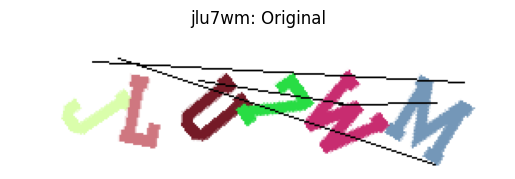

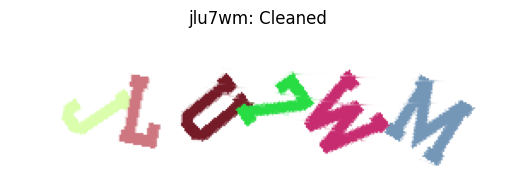

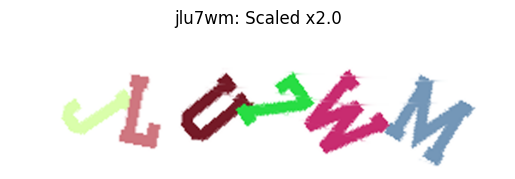

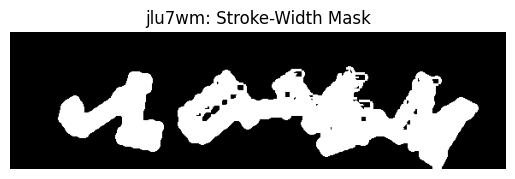

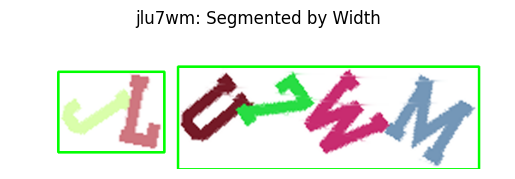

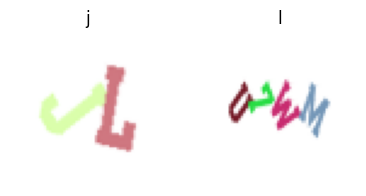

Number of characters expected: 6
Number of characters extracted: 2


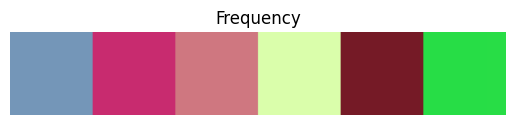

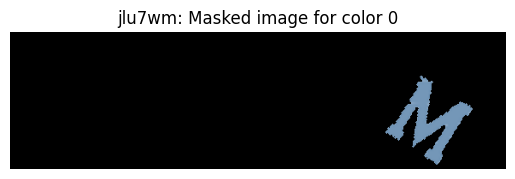

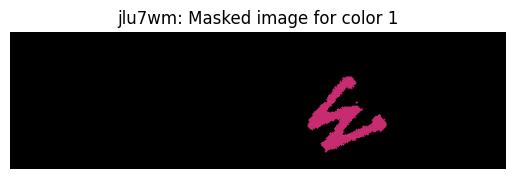

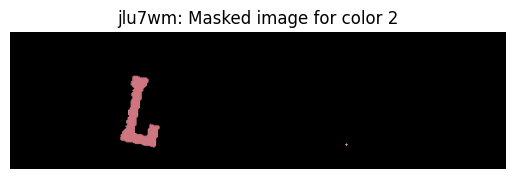

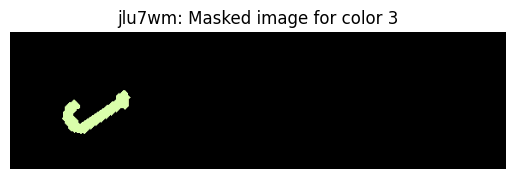

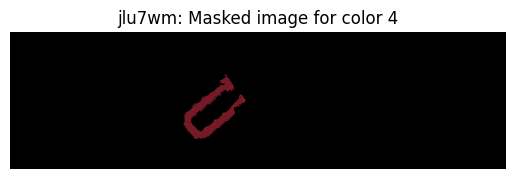

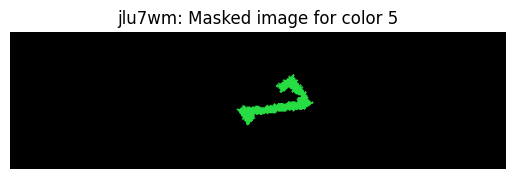

In [207]:
# label = "qhi5yn5j"
label = "jlu7wm"
img = get_img(label)

show_img(img, title=f"{label}: Original")

img_clean = remove_lines(img)
show_img(img_clean, title=f"{label}: Cleaned")

scale = 2.0
img_scaled = cv2.resize(img_clean, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
show_img(img_scaled, title=f"{label}: Scaled x{scale}")

vis, mask, boxes, chars = segment_by_color_stroke_width(img_scaled, min_width=2, max_width=8, out_size=(64, 64))
show_img(mask, title=f"{label}: Stroke-Width Mask")
show_img(vis, title=f"{label}: Segmented by Width")

# --- Plot the extracted characters ---
n = len(chars)
cols = min(n, 8)
rows = (n + cols - 1) // cols

plt.figure(figsize=(cols*2, rows*2))
for i, ch in enumerate(chars):
    plt.subplot(rows, cols, i+1)
    if len(ch.shape) == 2:
        plt.imshow(ch, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(ch, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    if i < len(label):
        plt.title(label[i])
plt.tight_layout()
plt.show()

expected_len = len(label)
extracted_len = len(chars)

print("Number of characters expected:", expected_len)
print("Number of characters extracted:", extracted_len)

# If number of characters extracted < expected, for each segment we split by colors

colors = get_top_colors(img_scaled, n_colors=len(label))
show_colors(colors, label="Frequency")

show_masked_images(img_scaled, colors)

In [208]:
# High contrast + Color based - 2x
def stroke_width_process(img):

    img_clean = remove_lines(img)
    
    scale = 2.0
    img_scaled = cv2.resize(img_clean, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)

    vis, mask, boxes, chars = segment_by_color_stroke_width(img_scaled, min_width=2, max_width=8)

    return chars

results = [0, 0]

rand_imgs = random.sample(train_files, 5000)
for f in rand_imgs:
    img = cv2.imread(train_dir + f)
    chars = stroke_width_process(img)
    if len(chars) == len(f[:-6]):
        results[0] += 1
    else:
        results[1] += 1

print(results, results[0]/sum(results))

[3792, 1208] 0.7584
